In [1]:


# Import necessary libraries
import pandas as pd
import numpy as np
import math
import seaborn as sns

from matplotlib import pylab
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
sns.set_style("whitegrid")
pylab.rcParams['figure.figsize'] = (5, 7)
sns.set_style("ticks")
import os
# Load the imaging data

## Setting Parameters for the different models

In [2]:

ParamsDict = {
"Mosaic":{"GenotypesPerBatch":12,"Period(days)":14,"StartingGenotypes":14,"FirstBatchLag":65,"color":"#EF6F6C"},
"Downstream":{"GenotypesPerBatch":20,"Period(days)":65,"StartingGenotypes":20,"FirstBatchLag":65,"color":"#3AD8DE"},
"NPC-Chimeroids":{"GenotypesPerBatch":20,"Period(days)":39,"StartingGenotypes":20,"FirstBatchLag":105,"color":"#95A4A5"},
"SingleDonor_organoids":{"GenotypesPerBatch":20,"Period(days)":105,"StartingGenotypes":20,"FirstBatchLag":105,"color":"#e83b71"}
}

figDir = "./figures"
if not os.path.exists(figDir):
    os.makedirs(figDir)

for c in list(ParamsDict.keys()):
    p1 = (ParamsDict[c]["FirstBatchLag"], ParamsDict[c]["GenotypesPerBatch"])
    p2 = ((ParamsDict[c]["FirstBatchLag"]+ParamsDict[c]["Period(days)"]), (ParamsDict[c]["GenotypesPerBatch"]*2))
    m = (p2[1]-p1[1])/(p2[0 ]-p1[0])
    y = m * (p2[0] - p1[0]) + p1[1]
    q = y - m*p2[0]
    ParamsDict[c]["m"] = m
    ParamsDict[c]["q"] = q

ParamsDict

{'Mosaic': {'GenotypesPerBatch': 12,
  'Period(days)': 14,
  'StartingGenotypes': 14,
  'FirstBatchLag': 65,
  'color': '#EF6F6C',
  'm': 0.8571428571428571,
  'q': -43.71428571428571},
 'Downstream': {'GenotypesPerBatch': 20,
  'Period(days)': 65,
  'StartingGenotypes': 20,
  'FirstBatchLag': 65,
  'color': '#3AD8DE',
  'm': 0.3076923076923077,
  'q': 0.0},
 'NPC-Chimeroids': {'GenotypesPerBatch': 20,
  'Period(days)': 39,
  'StartingGenotypes': 20,
  'FirstBatchLag': 105,
  'color': '#95A4A5',
  'm': 0.5128205128205128,
  'q': -33.84615384615384},
 'SingleDonor_organoids': {'GenotypesPerBatch': 20,
  'Period(days)': 105,
  'StartingGenotypes': 20,
  'FirstBatchLag': 105,
  'color': '#e83b71',
  'm': 0.19047619047619047,
  'q': 0.0}}

In [3]:
ndays = 50000
ScalabilityDF = pd.DataFrame(index=range(ndays))
ScalabilityDF["days"] = range(ndays)
ScalabilityDF

def split(a, step):
    return [a[i:i+step] for i in range(0, len(a), step)]


for c in list(ParamsDict.keys()):
    m = ParamsDict[c]["m"]
    q = ParamsDict[c]["q"]
    x = ScalabilityDF["days"]
    y = m * x + q
    ScalabilityDF[c] = y
    lag  = pd.Series(m*np.array(range(ParamsDict[c]["FirstBatchLag"]))+q, 
                     index = range(ParamsDict[c]["FirstBatchLag"])).to_frame("Lag_{}".format(c))
    ScalabilityDF = pd.concat([ScalabilityDF,lag], axis = 1)
    ScalabilityDF["Lag_{}".format(c)] = ScalabilityDF["Lag_{}".format(c)].fillna(0)
    ScalabilityDF["{}.Shifted".format(c)] = ScalabilityDF[c] - ScalabilityDF["Lag_{}".format(c)]
    
    t = ScalabilityDF.loc[ScalabilityDF["days"] >= ParamsDict[c]["FirstBatchLag"], "{}.Shifted".format(c)]
    for n,i in enumerate(list(split(t.index.tolist(), ParamsDict[c]["Period(days)"]))):
        for l in list(i):
            day = l
            ScalabilityDF.loc[ScalabilityDF["days"] == day,"CollectedBatch.{}".format(c)] = n
    MapDict = {i: ScalabilityDF.loc[ScalabilityDF["CollectedBatch.{}".format(c)] == i,c].values[0] for i in ScalabilityDF["CollectedBatch.{}".format(c)].unique().tolist() if np.isnan(i) == False}
    ScalabilityDF["{}.Discrete".format(c)] = ScalabilityDF["CollectedBatch.{}".format(c)].replace(MapDict).fillna(ScalabilityDF["{}.Shifted".format(c)])
ScalabilityDF

,days,Mosaic,Lag_Mosaic,Mosaic.Shifted,CollectedBatch.Mosaic,Mosaic.Discrete,Downstream,Lag_Downstream,Downstream.Shifted,CollectedBatch.Downstream,...,NPC-Chimeroids,Lag_NPC-Chimeroids,NPC-Chimeroids.Shifted,CollectedBatch.NPC-Chimeroids,NPC-Chimeroids.Discrete,SingleDonor_organoids,Lag_SingleDonor_organoids,SingleDonor_organoids.Shifted,CollectedBatch.SingleDonor_organoids,SingleDonor_organoids.Discrete
0,0,-43.714286,-43.714286,0.000000,NaN,0.0,0.000000,0.000000,0.000000,NaN,...,-33.846154,-33.846154,0.000000,NaN,0.0,0.000000,0.000000,0.000000,NaN,0.0
1,1,-42.857143,-42.857143,0.000000,NaN,0.0,0.307692,0.307692,0.000000,NaN,...,-33.333333,-33.333333,0.000000,NaN,0.0,0.190476,0.190476,0.000000,NaN,0.0
2,2,-42.000000,-42.000000,0.000000,NaN,0.0,0.615385,0.615385,0.000000,NaN,...,-32.820513,-32.820513,0.000000,NaN,0.0,0.380952,0.380952,0.000000,NaN,0.0
3,3,-41.142857,-41.142857,0.000000,NaN,0.0,0.923077,0.923077,0.000000,NaN,...,-32.307692,-32.307692,0.000000,NaN,0.0,0.571429,0.571429,0.000000,NaN,0.0
4,4,-40.285714,-40.285714,0.000000,NaN,0.0,1.230769,1.230769,0.000000,NaN,...,-31.794872,-31.794872,0.000000,NaN,0.0,0.761905,0.761905,0.000000,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,42809.142857,0.000000,42809.142857,3566.0,42804.0,15383.076923,0.000000,15383.076923,768.0,...,25604.615385,0.000000,25604.615385,1279.0,25600.0,9522.857143,0.000000,9522.857143,475.0,9520.0
49996,49996,42810.000000,0.000000,42810.000000,3566.0,42804.0,15383.384615,0.000000,15383.384615,768.0,...,25605.128205,0.000000,25605.128205,1279.0,25600.0,9523.047619,0.000000,9523.047619,475.0,9520.0
49997,49997,42810.857143,0.000000,42810.857143,3566.0,42804.0,15383.692308,0.000000,15383.692308,768.0,...,25605.641026,0.000000,25605.641026,1279.0,25600.0,9523.238095,0.000000,9523.238095,475.0,9520.0
49998,49998,42811.714286,0.000000,42811.714286,3566.0,42804.0,15384.000000,0.000000,15384.000000,768.0,...,25606.153846,0.000000,25606.153846,1279.0,25600.0,9523.428571,0.000000,9523.428571,475.0,9520.0


In [4]:
ScalabilityDF.loc[105]

days                                    105.000000
Mosaic                                   46.285714
Lag_Mosaic                                0.000000
Mosaic.Shifted                           46.285714
CollectedBatch.Mosaic                     2.000000
Mosaic.Discrete                          36.000000
Downstream                               32.307692
Lag_Downstream                            0.000000
Downstream.Shifted                       32.307692
CollectedBatch.Downstream                 0.000000
Downstream.Discrete                      20.000000
NPC-Chimeroids                           20.000000
Lag_NPC-Chimeroids                        0.000000
NPC-Chimeroids.Shifted                   20.000000
CollectedBatch.NPC-Chimeroids             0.000000
NPC-Chimeroids.Discrete                  20.000000
SingleDonor_organoids                    20.000000
Lag_SingleDonor_organoids                 0.000000
SingleDonor_organoids.Shifted            20.000000
CollectedBatch.SingleDonor_orga

In [5]:
DiscreteDF = ScalabilityDF[[i for i in ScalabilityDF.columns if ".Discrete" in i or i == "days" ]].melt("days")
Continous = ScalabilityDF[[i for i in ScalabilityDF.columns if ".Shifted" in i or i == "days" ]].melt("days")



# All protocols early target lines 1000

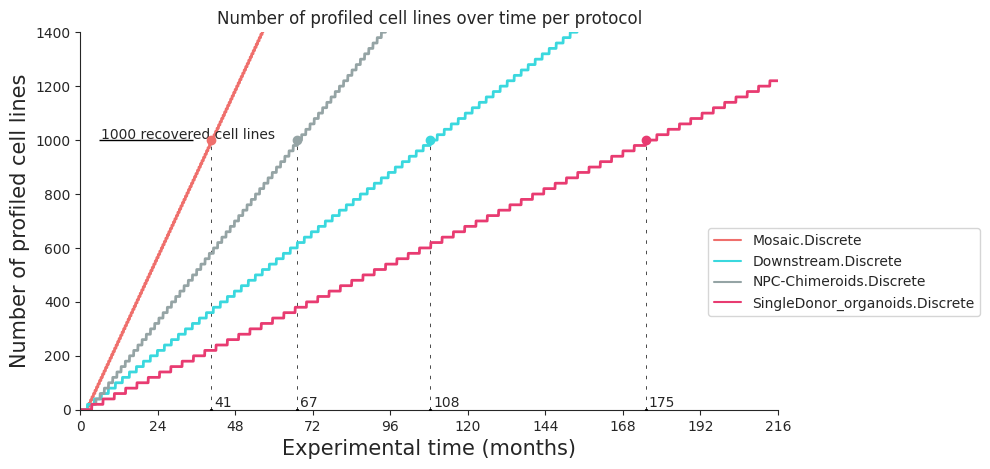

In [18]:
NlinesTarget = 1000
MaxDays = 7000
MaxRecovery = 1400
interval = 24

#DiscreteDF["Time (months)"] = DiscreteDF.days/30

fig,ax = plt.subplots(ncols=1,nrows=1, figsize=(9, 5),dpi=100 )

maxInterceptDict = {}
for c in list(ParamsDict.keys()):
    plt.scatter(x = (NlinesTarget-ParamsDict[c]["q"])/ParamsDict[c]["m"], 
                y = NlinesTarget, color = ParamsDict[c]["color"],zorder=100)
    maxInterceptDict[c] = (NlinesTarget-ParamsDict[c]["q"])/ParamsDict[c]["m"]
    plt.vlines(x=maxInterceptDict[c],ymin=0, ymax=NlinesTarget, 
               color='black',linestyle=(0, (5, 10)), linewidth = .5 )
    plt.scatter(x = (NlinesTarget-ParamsDict[c]["q"])/ParamsDict[c]["m"], s=2,
                y = 0, color = "black",zorder=100)
    ax.annotate(round(((NlinesTarget-ParamsDict[c]["q"])/ParamsDict[c]["m"])/30),
                xytext=(2, 2), textcoords='offset points',fontsize=10,
            xy=((NlinesTarget-ParamsDict[c]["q"])/ParamsDict[c]["m"], 0), xycoords='data')


sns.lineplot(data=DiscreteDF, x="days", y="value",hue="variable", ax = ax, linewidth = 2,
             palette={i+".Discrete":ParamsDict[i]["color"] for i in list(ParamsDict.keys())})

# Plot reference line for NlinesTarget
CenterLine = min(list(maxInterceptDict.values()))/7
plt.hlines(y=NlinesTarget,xmin=CenterLine*1, xmax=CenterLine*6,
           color='black' , linewidth = 1 )

ax.annotate("{} recovered cell lines".format(NlinesTarget),
            xytext=(0.1, 0.1), textcoords='offset fontsize',
        xy=(CenterLine*1, NlinesTarget), xycoords='data')


# Prep labels
MonthsDays = [i for i in DiscreteDF.loc[DiscreteDF["days"] <= MaxDays,"days"].unique().tolist() if i%30 == 0]
#ticks = MonthsDays[::(len(MonthsDays) // (nTicks-1))]
ticks = MonthsDays[::interval]

ticklabels = [int(i/30) for i in ticks]

ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)

ax.set_title('Number of profiled cell lines over time per protocol')

ax.set_xlabel('Experimental days') # Y label
ax.set_ylabel('Number of profiled cell lines') # Y label
ax.set_xlim([0, max(ticks)])
ax.set_ylim([0, MaxRecovery])

sns.despine(fig=ax.figure,trim=True)

ax.set_xlabel('Experimental time (months)', fontsize=15) # X label
ax.set_ylabel('Number of profiled cell lines', fontsize=15) # Y label
ax.legend(bbox_to_anchor=(1.3, .5))
ax.tick_params(axis='both', which='major', labelsize=10)

fig.savefig(figDir+"/Scalability.4000days.Chimeroids.svg", format='svg', bbox_inches='tight')


# Multiplexing only early target lines 1000

In [7]:
ParamsDictSS = ParamsDict.copy()
del ParamsDictSS["NPC-Chimeroids"]
del ParamsDictSS["SingleDonor_organoids"]

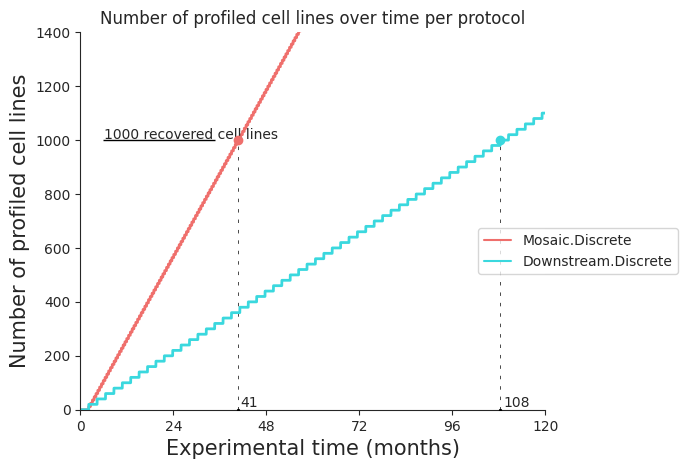

In [15]:
NlinesTarget = 1000
MaxDays = 4000
MaxRecovery = 1400
interval = 24

#DiscreteDF["Time (months)"] = DiscreteDF.days/30
DiscreteDFSS = DiscreteDF[(~DiscreteDF["variable"].str.contains("SingleDonor_organoids.Discrete")) & (~DiscreteDF["variable"].str.contains("NPC-Chimeroids.Discrete"))]

fig,ax = plt.subplots(ncols=1,nrows=1, figsize=(6, 5),dpi=100 )

maxInterceptDict = {}
for c in list(ParamsDictSS.keys()):
    plt.scatter(x = (NlinesTarget-ParamsDictSS[c]["q"])/ParamsDictSS[c]["m"], 
                y = NlinesTarget, color = ParamsDictSS[c]["color"],zorder=100)
    maxInterceptDict[c] = (NlinesTarget-ParamsDictSS[c]["q"])/ParamsDictSS[c]["m"]
    plt.vlines(x=maxInterceptDict[c],ymin=0, ymax=NlinesTarget, 
               color='black',linestyle=(0, (5, 10)), linewidth = .5 )
    plt.scatter(x = (NlinesTarget-ParamsDictSS[c]["q"])/ParamsDictSS[c]["m"], s=2,
                y = 0, color = "black",zorder=100)
    ax.annotate(round(((NlinesTarget-ParamsDictSS[c]["q"])/ParamsDictSS[c]["m"])/30),
                xytext=(2, 2), textcoords='offset points',fontsize=10,
            xy=((NlinesTarget-ParamsDictSS[c]["q"])/ParamsDictSS[c]["m"], 0), xycoords='data')


sns.lineplot(data=DiscreteDFSS, x="days", y="value",hue="variable", ax = ax, linewidth = 2,
             palette={i+".Discrete":ParamsDictSS[i]["color"] for i in list(ParamsDictSS.keys())})

# Plot reference line for NlinesTarget
CenterLine = min(list(maxInterceptDict.values()))/7
plt.hlines(y=NlinesTarget,xmin=CenterLine*1, xmax=CenterLine*6,
           color='black' , linewidth = 1 )

ax.annotate("{} recovered cell lines".format(NlinesTarget),
            xytext=(0.1, 0.1), textcoords='offset fontsize',
        xy=(CenterLine*1, NlinesTarget), xycoords='data')


# Prep labels
MonthsDays = [i for i in DiscreteDFSS.loc[DiscreteDFSS["days"] <= MaxDays,"days"].unique().tolist() if i%30 == 0]
#ticks = MonthsDays[::(len(MonthsDays) // (nTicks-1))]
ticks = MonthsDays[::interval]

ticklabels = [int(i/30) for i in ticks]

ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)

ax.set_title('Number of profiled cell lines over time per protocol')

ax.set_xlabel('Experimental days') # Y label
ax.set_ylabel('Number of profiled cell lines') # Y label
ax.set_xlim([0, max(ticks)])
ax.set_ylim([0, MaxRecovery])

sns.despine(fig=ax.figure,trim=True)

ax.set_xlabel('Experimental time (months)', fontsize=15) # X label
ax.set_ylabel('Number of profiled cell lines', fontsize=15) # Y label
ax.legend(bbox_to_anchor=(1.3, .5))
ax.tick_params(axis='both', which='major', labelsize=10)

fig.savefig(figDir+"/Scalability.4000days.svg", format='svg', bbox_inches='tight')


# All protocols max 100 lines

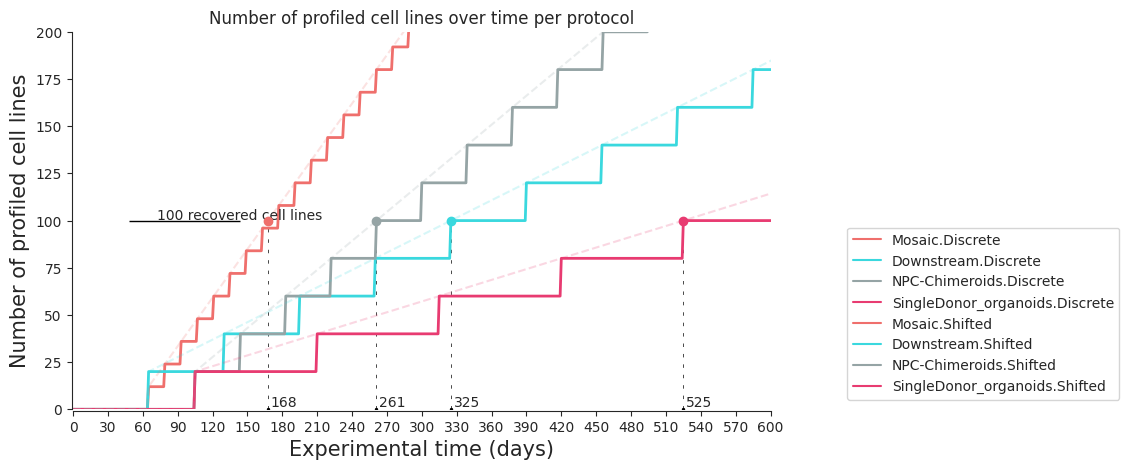

In [17]:
NlinesTarget = 100
MaxDays = 600
MaxRecovery = 200
interval = 30

#DiscreteDF["Time (months)"] = DiscreteDF.days/30

fig,ax = plt.subplots(ncols=1,nrows=1, figsize=(9, 5),dpi=100 )

maxInterceptDict = {}
for c in list(ParamsDict.keys()):
    plt.scatter(x = (NlinesTarget-ParamsDict[c]["q"])/ParamsDict[c]["m"], 
                y = NlinesTarget, color = ParamsDict[c]["color"],zorder=100)
    maxInterceptDict[c] = (NlinesTarget-ParamsDict[c]["q"])/ParamsDict[c]["m"]
    plt.vlines(x=maxInterceptDict[c],ymin=0, ymax=NlinesTarget, 
               color='black',linestyle=(0, (5, 10)), linewidth = .5 )
    plt.scatter(x = (NlinesTarget-ParamsDict[c]["q"])/ParamsDict[c]["m"], s=2,
                y = 0, color = "black",zorder=100)
    ax.annotate(round((NlinesTarget-ParamsDict[c]["q"])/ParamsDict[c]["m"]),
                xytext=(2, 2), textcoords='offset points',fontsize=10,
            xy=((NlinesTarget-ParamsDict[c]["q"])/ParamsDict[c]["m"], 0), xycoords='data')


sns.lineplot(data=DiscreteDF, x="days", y="value",hue="variable", ax = ax, linewidth = 2,
             palette={i+".Discrete":ParamsDict[i]["color"] for i in list(ParamsDict.keys())})

sns.lineplot(data=Continous, x="days", y="value",hue="variable", ax = ax, linestyle="--",alpha=.2,
             palette={i+".Shifted":ParamsDict[i]["color"] for i in list(ParamsDict.keys())})

# Plot reference line for NlinesTarget
CenterLine = min(list(maxInterceptDict.values()))/7
plt.hlines(y=NlinesTarget,xmin=CenterLine*2, xmax=CenterLine*6,
           color='black' , linewidth = 1 )

ax.annotate("{} recovered cell lines".format(NlinesTarget),
            xytext=(2, 0.1), textcoords='offset fontsize',
        xy=(CenterLine*2, NlinesTarget), xycoords='data')

# Prep labels
#MonthsDays = [i for i in DiscreteDF.loc[DiscreteDF["days"] <= MaxDays,"days"].unique().tolist() if i%30 == 0]
#ticks = MonthsDays[::(len(MonthsDays) // (nTicks-1))]
ticks = DiscreteDF.loc[DiscreteDF["days"] <= MaxDays,"days"].unique().tolist()[::interval]

#ticklabels = [int(i/30) for i in ticks]
ax.set_xticks(ticks)


ax.set_title('Number of profiled cell lines over time per protocol')

ax.set_xlabel('Experimental days') # Y label
ax.set_ylabel('Number of profiled cell lines') # Y label
ax.set_xlim([0, max(ticks)])
ax.set_ylim([0, MaxRecovery])

sns.despine(fig=ax.figure,offset=True,trim=True)

ax.set_xlabel('Experimental time (days)', fontsize=15) # X label
ax.set_ylabel('Number of profiled cell lines', fontsize=15) # Y label
ax.legend(bbox_to_anchor=(1.1, .5))
ax.tick_params(axis='both', which='major', labelsize=10)
fig.savefig(figDir+"/Scalability.350days.Chimeroids.svg", format='svg', bbox_inches='tight')


# Multiplexing only target 100 lines

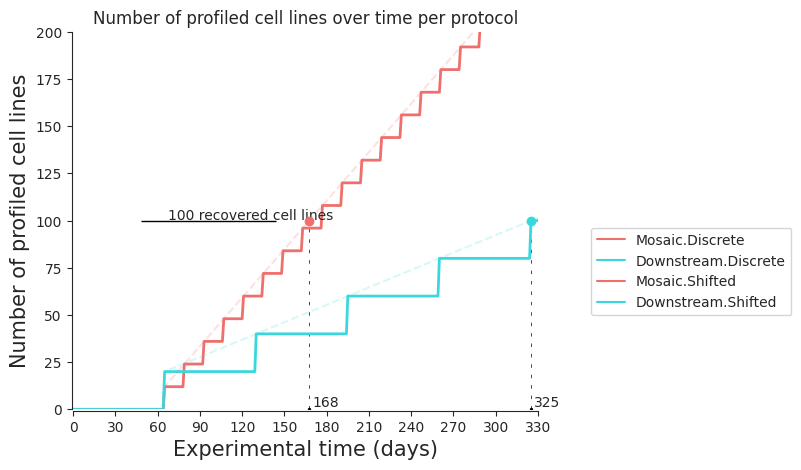

In [16]:
NlinesTarget = 100
MaxDays = 350
MaxRecovery = 200
interval = 30

#DiscreteDF["Time (months)"] = DiscreteDF.days/30
DiscreteDFSS = DiscreteDF[(~DiscreteDF["variable"].str.contains("SingleDonor_organoids")) & (~DiscreteDF["variable"].str.contains("NPC-Chimeroids"))]
ContinousSS = Continous[(~Continous["variable"].str.contains("SingleDonor_organoids")) & (~Continous["variable"].str.contains("NPC-Chimeroids"))]

fig,ax = plt.subplots(ncols=1,nrows=1, figsize=(6, 5),dpi=100 )

maxInterceptDict = {}
for c in list(ParamsDictSS.keys()):
    plt.scatter(x = (NlinesTarget-ParamsDictSS[c]["q"])/ParamsDictSS[c]["m"], 
                y = NlinesTarget, color = ParamsDictSS[c]["color"],zorder=100)
    maxInterceptDict[c] = (NlinesTarget-ParamsDictSS[c]["q"])/ParamsDictSS[c]["m"]
    plt.vlines(x=maxInterceptDict[c],ymin=0, ymax=NlinesTarget, 
               color='black',linestyle=(0, (5, 10)), linewidth = .5 )
    plt.scatter(x = (NlinesTarget-ParamsDictSS[c]["q"])/ParamsDictSS[c]["m"], s=2,
                y = 0, color = "black",zorder=100)
    ax.annotate(round((NlinesTarget-ParamsDictSS[c]["q"])/ParamsDictSS[c]["m"]),
                xytext=(2, 2), textcoords='offset points',fontsize=10,
            xy=((NlinesTarget-ParamsDictSS[c]["q"])/ParamsDictSS[c]["m"], 0), xycoords='data')


sns.lineplot(data=DiscreteDFSS, x="days", y="value",hue="variable", ax = ax, linewidth = 2,
             palette={i+".Discrete":ParamsDictSS[i]["color"] for i in list(ParamsDictSS.keys())})

sns.lineplot(data=ContinousSS, x="days", y="value",hue="variable", ax = ax, linestyle="--",alpha=.2,
             palette={i+".Shifted":ParamsDictSS[i]["color"] for i in list(ParamsDictSS.keys())})

# Plot reference line for NlinesTarget
CenterLine = min(list(maxInterceptDict.values()))/7
plt.hlines(y=NlinesTarget,xmin=CenterLine*2, xmax=CenterLine*6,
           color='black' , linewidth = 1 )

ax.annotate("{} recovered cell lines".format(NlinesTarget),
            xytext=(2, 0.1), textcoords='offset fontsize',
        xy=(CenterLine*2, NlinesTarget), xycoords='data')

# Prep labels
#MonthsDays = [i for i in DiscreteDF.loc[DiscreteDF["days"] <= MaxDays,"days"].unique().tolist() if i%30 == 0]
#ticks = MonthsDays[::(len(MonthsDays) // (nTicks-1))]
ticks = DiscreteDFSS.loc[DiscreteDFSS["days"] <= MaxDays,"days"].unique().tolist()[::interval]

#ticklabels = [int(i/30) for i in ticks]
ax.set_xticks(ticks)


ax.set_title('Number of profiled cell lines over time per protocol')

ax.set_xlabel('Experimental days') # Y label
ax.set_ylabel('Number of profiled cell lines') # Y label
ax.set_xlim([0, max(ticks)])
ax.set_ylim([0, MaxRecovery])

sns.despine(fig=ax.figure,offset=True,trim=True)

ax.set_xlabel('Experimental time (days)', fontsize=15) # X label
ax.set_ylabel('Number of profiled cell lines', fontsize=15) # Y label
ax.legend(bbox_to_anchor=(1.1, .5))
ax.tick_params(axis='both', which='major', labelsize=10)
fig.savefig(figDir+"/Scalability.350days.svg", format='svg', bbox_inches='tight')
